## What This Notebook Does

This notebook calculates how easy it is for people in each neighbourhood (LSOA) to access a CT scanner, based on real travel times. We use a method called the Enhanced 3-Step Floating Catchment Area (E3SFCA), which goes beyond simple distance to include:

- Actual travel time by car and public transport
- Population demand per neighbourhood
- Number of CT scanners available at each hospital or diagnostic centre
- A weighting system that gives more credit to closer facilities

### Step-by-Step Explanation

1. Identify the CT Sites  
   We start by combining NHS Community Diagnostic Centres (CDCs) and Acute Hospitals, and we keep only those that actually have CT scanners.

2. Trim the Giant Travel Time Matrix  
   Instead of using all possible LSOA-to-LSOA travel times (millions of combinations), we filter the matrix to keep only the routes where the destination is a CT scanner site, and only if the trip is reasonably short (e.g. under 60 minutes). This makes the data faster and easier to work with.

3. Apply a Travel Time Decay  
   We assume people are more likely to go to nearby scanners, so we apply a weighting system: short trips are weighted more heavily than long trips.

4. Calculate Supply-to-Demand Ratios  
   For each CT scanner location, we calculate how many people (weighted by travel time) are trying to access it, and compare that to the number of scanners it has.

5. Score Each Neighbourhood  
   For every LSOA, we look at which CT sites it can reach within the time limit. We sum the supply-to-demand ratios of those sites, adjusted for travel time, to get a final accessibility score.

6. Repeat for Each Travel Mode  
   We calculate separate scores for:
   - Car travel (e3sfca_score_car)
   - Public transport during peak hours (e3sfca_score_pt_peak)
   - Public transport during off-peak hours (e3sfca_score_pt_nonpeak)

7. Export and Visualise  
   These scores are added back to the LSOA GeoDataFrame so they can be visualised as maps or exported for further analysis.

### Why It Matters

This approach gives a realistic picture of NHS CT scanner accessibility, accounting for both population demand and how hard it is to get to a scanner. It supports better planning, site placement, and equity assessments — especially across rural, deprived, or underserved areas.


In [17]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import warnings
import seaborn as sns
import mapclassify


warnings.filterwarnings("ignore")

# ----------------------------------------------------------
# Step 1 – Define File Paths and Load Processed Inputs
# ----------------------------------------------------------

# Base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# Input files (baseline access and facility logic)
lsoa_access_path = os.path.join(processed_dir, "gdf_lsoa_CT_accessibility_2024.gpkg")
travel_matrix_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")
cdc_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Community_Diagnostic_Centres_Capability.csv")
acute_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Acute_Hospitals_Capability.csv")

# Ensure path to LSOA base demographic and demand file is defined
lsoa_gpkg_path = os.path.join(
    processed_dir,
    "LSOA_CT_Demand_with_Demographics_2024_v1.gpkg"
)

# Output folder
output_dir = os.path.join(base_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)

In [2]:
# ----------------------------------------------------------
# Step 2 – Load Input Files
# ----------------------------------------------------------

# Load baseline accessibility GeoDataFrame
gdf_lsoa = gpd.read_file(lsoa_access_path)
print(f"Baseline LSOA access file loaded: {gdf_lsoa.shape}")

# Load site capability files
df_cdc = pd.read_csv(cdc_path)
df_acute = pd.read_csv(acute_path)
print(f"CDC sites: {df_cdc.shape[0]} rows | Acute sites: {df_acute.shape[0]} rows")

# Load travel matrix with car and PT times
df_travel = pd.read_csv(travel_matrix_path)
print(f"Travel matrix loaded: {df_travel.shape}")


Baseline LSOA access file loaded: (3451, 7)
CDC sites: 24 rows | Acute sites: 18 rows
Travel matrix loaded: (11003925, 5)


In [3]:
# ----------------------------------------------------------
# Step 3 – Filter Travel Matrix to CT-Capable Sites (Car Mode)
# ----------------------------------------------------------

# Combine CDC and Acute sites
df_sites = pd.concat([df_cdc, df_acute], ignore_index=True)

# Clean column names just in case
df_sites.columns = df_sites.columns.str.strip()

# Filter to CT-capable sites only
df_sites_ct = df_sites[df_sites["CT Scanners"] > 0].copy()
print(f"CT-capable sites found: {df_sites_ct.shape[0]}")

# Extract valid LSOA codes where CT scanners exist
ct_lsoa_codes = df_sites_ct["lsoa21cd"].dropna().unique()

# Filter travel matrix where destination is a CT site (by LSOA code)
df_travel_car = df_travel[df_travel["destination_name"].isin(ct_lsoa_codes)].copy()
print(f"Filtered travel matrix for CT destinations (car mode): {df_travel_car.shape}")

# Optional: Apply travel time threshold (e.g. ≤ 60 minutes)
df_travel_car = df_travel_car[df_travel_car["travel_time_car"] <= 60].copy()
print(f"Filtered travel matrix within 60 min (car): {df_travel_car.shape}")


CT-capable sites found: 36
Filtered travel matrix for CT destinations (car mode): (98338, 5)
Filtered travel matrix within 60 min (car): (19253, 5)


In [4]:
# ----------------------------------------------------------
# Step 4 – Column Header Checks (All Inputs)
# ----------------------------------------------------------

# Travel matrix columns
print("\nTravel Matrix Columns:")
print(df_travel.columns.to_list())

# CT Sites table columns (after merge)
print("\nCT Site Capability Columns:")
print(df_sites_ct.columns.to_list())

# LSOA demand GeoDataFrame columns
print("\nLSOA Demographic Columns:")
print(gdf_lsoa.columns.to_list())

# Quick verification sample
print("\nSample travel matrix row:")
print(df_travel_car.head(1).T)

print("\nSample CT site row:")
print(df_sites_ct[["Name", "CT Scanners", "lsoa21cd", "latitude", "longitude"]].head(1).T)

print("\nSample LSOA access row:")
print(gdf_lsoa[["lsoa21cd", "ct_total_demand", "total_population"]].head(1).T)



Travel Matrix Columns:
['origin_name', 'destination_name', 'travel_time_car', 'travel_time_pt_peak', 'travel_time_pt_nonpeak']

CT Site Capability Columns:
['Code', 'Name', 'CT Scanners', 'MRI Scanners', 'Endoscopy Rooms', 'Address 1', 'Address 2', 'Address 3', 'Address 4', 'Address 5', 'Postcode', 'Type', 'Parent Organisation Code', 'Parent Organisation Name', 'postcode', 'latitude', 'longitude', 'lsoa21cd', 'msoa21cd', 'oa21cd', 'icb_code', 'local_authority', 'Trust Name']

LSOA Demographic Columns:
['lsoa21cd', 'ct_access_car_lt_20', 'ct_access_car_20_40', 'ct_access_car_gt_40', 'ct_total_demand', 'total_population', 'geometry']

Sample travel matrix row:
                              649
origin_name             E01014659
destination_name        E01015569
travel_time_car         46.115808
travel_time_pt_peak     80.075808
travel_time_pt_nonpeak  80.075808

Sample CT site row:
                                  0
Name         Bsw Banes Locality CDC
CT Scanners                       1

In [5]:
# ----------------------------------------------------------
# Step 5 – Apply Travel Time Decay Function (Car Mode, 0–40 min)
# ----------------------------------------------------------

# Updated stepwise decay function (more granular across 0–40 min)
def apply_decay_car(travel_time):
    """
    Decay weights for car travel time:
    - 0–10 min: 1.0
    - 10–20 min: 0.75
    - 20–30 min: 0.4
    - 30–40 min: 0.2
    - >40 min: 0.05
    """
    if travel_time <= 10:
        return 1.0
    elif travel_time <= 20:
        return 0.75
    elif travel_time <= 30:
        return 0.4
    elif travel_time <= 40:
        return 0.2
    else:
        return 0.05

# Apply decay weights to the filtered travel matrix (car mode)
df_travel_car["decay_weight"] = df_travel_car["travel_time_car"].apply(apply_decay_car)

# Summary check: count of each decay weight
print("Decay weights applied (car mode):")
print(df_travel_car["decay_weight"].value_counts().sort_index())


Decay weights applied (car mode):
decay_weight
0.05    11263
0.20     2837
0.40     2301
0.75     1947
1.00      905
Name: count, dtype: int64


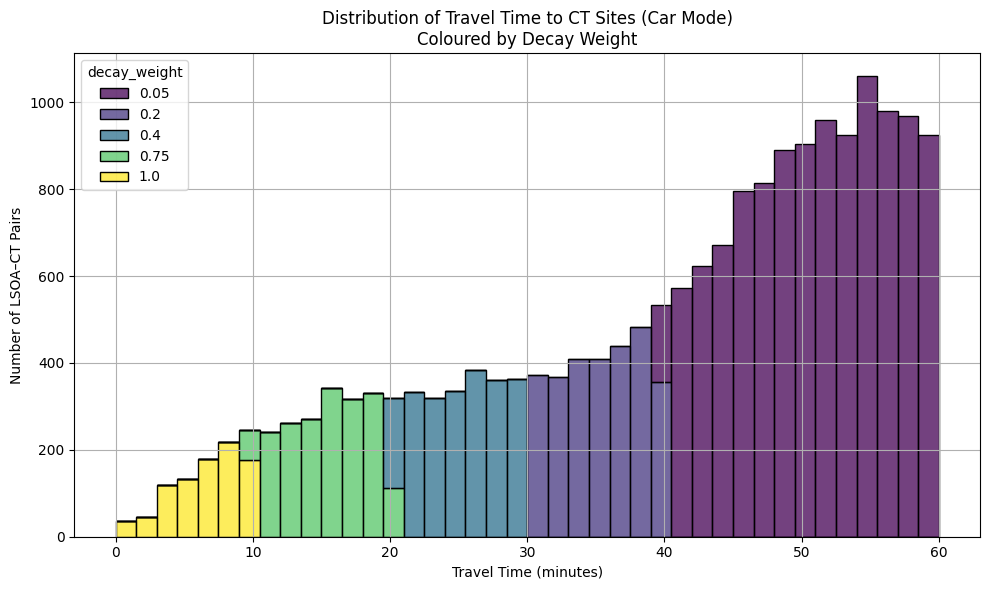

In [8]:
# ----------------------------------------------------------
# Step 5a – Visualise Decay Weights by Travel Time (Car Mode)
# ----------------------------------------------------------


# Set style
plt.style.use("default")

# Histogram of travel times with decay weights
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_travel_car,
    x="travel_time_car",
    bins=40,
    hue="decay_weight",
    palette="viridis",
    multiple="stack",
    edgecolor="black"
)
plt.title("Distribution of Travel Time to CT Sites (Car Mode)\nColoured by Decay Weight")
plt.xlabel("Travel Time (minutes)")
plt.ylabel("Number of LSOA–CT Pairs")
plt.grid(True)
plt.tight_layout()
plt.show()



In [9]:
# ----------------------------------------------------------
# Step 6 – Compute Supply-to-Demand Ratios at Each CT Site (Rj)
# ----------------------------------------------------------

# Merge travel matrix with LSOA demand (e.g. total_population or ct_total_demand)
# Match on origin_name ↔ lsoa21cd
df_travel_car = df_travel_car.merge(
    gdf_lsoa[["lsoa21cd", "ct_total_demand"]],
    how="left",
    left_on="origin_name",
    right_on="lsoa21cd"
)

# Drop rows with missing demand
df_travel_car = df_travel_car.dropna(subset=["ct_total_demand"])

# Calculate weighted demand per row
df_travel_car["weighted_demand"] = df_travel_car["ct_total_demand"] * df_travel_car["decay_weight"]

# Group by CT destination (destination_name = LSOA code of CT site)
# Sum total weighted demand seen by each CT site
df_site_demand = df_travel_car.groupby("destination_name")["weighted_demand"].sum().reset_index()
df_site_demand.rename(columns={"weighted_demand": "total_weighted_demand"}, inplace=True)

# Merge scanner supply per CT site (from df_sites_ct)
df_site_supply = df_sites_ct[["lsoa21cd", "CT Scanners"]].copy()
df_site_supply.rename(columns={"lsoa21cd": "destination_name"}, inplace=True)

# Merge demand and supply for final Rj calculation
df_site_rj = df_site_demand.merge(df_site_supply, on="destination_name", how="left")

# Replace missing CT supply with 1 (default if unknown)
df_site_rj["CT Scanners"] = df_site_rj["CT Scanners"].fillna(1)

# Compute Rj: scanner supply / total weighted demand
df_site_rj["Rj"] = df_site_rj["CT Scanners"] / df_site_rj["total_weighted_demand"]

# Clean up: keep only destination_name and Rj for downstream scoring
df_rj_car = df_site_rj[["destination_name", "Rj"]].copy()
print("Supply-to-demand ratios (Rj) calculated for CT sites (car mode):")
print(df_rj_car.describe())


Supply-to-demand ratios (Rj) calculated for CT sites (car mode):
              Rj
count  29.000000
mean    0.000077
std     0.000044
min     0.000017
25%     0.000037
50%     0.000072
75%     0.000097
max     0.000180


In [10]:
# ----------------------------------------------------------
# Step 7 – Compute Final E3SFCA Accessibility Score per LSOA (Car Mode)
# ----------------------------------------------------------

# Step 7.1 – Merge Rj values back onto filtered travel matrix
df_travel_car = df_travel_car.merge(
    df_rj_car,
    on="destination_name",
    how="left"
)

# Drop rows with missing Rj (if any)
df_travel_car = df_travel_car.dropna(subset=["Rj"])

# Step 7.2 – Compute Rj * decay_weight for each origin–destination pair
df_travel_car["access_component"] = df_travel_car["Rj"] * df_travel_car["decay_weight"]

# Step 7.3 – Aggregate final accessibility score per origin LSOA
df_e3sfca_car = df_travel_car.groupby("origin_name")["access_component"].sum().reset_index()
df_e3sfca_car.rename(columns={"origin_name": "lsoa21cd", "access_component": "e3sfca_score_car"}, inplace=True)

# Step 7.4 – Merge score back to base GeoDataFrame
gdf_lsoa = gdf_lsoa.merge(df_e3sfca_car, on="lsoa21cd", how="left")

# Final check
print("Final E3SFCA scores (car mode) merged into GeoDataFrame:")
print(gdf_lsoa[["lsoa21cd", "e3sfca_score_car"]].describe())


Final E3SFCA scores (car mode) merged into GeoDataFrame:
       e3sfca_score_car
count       3444.000000
mean           0.000093
std            0.000051
min            0.000002
25%            0.000052
50%            0.000091
75%            0.000119
max            0.000277


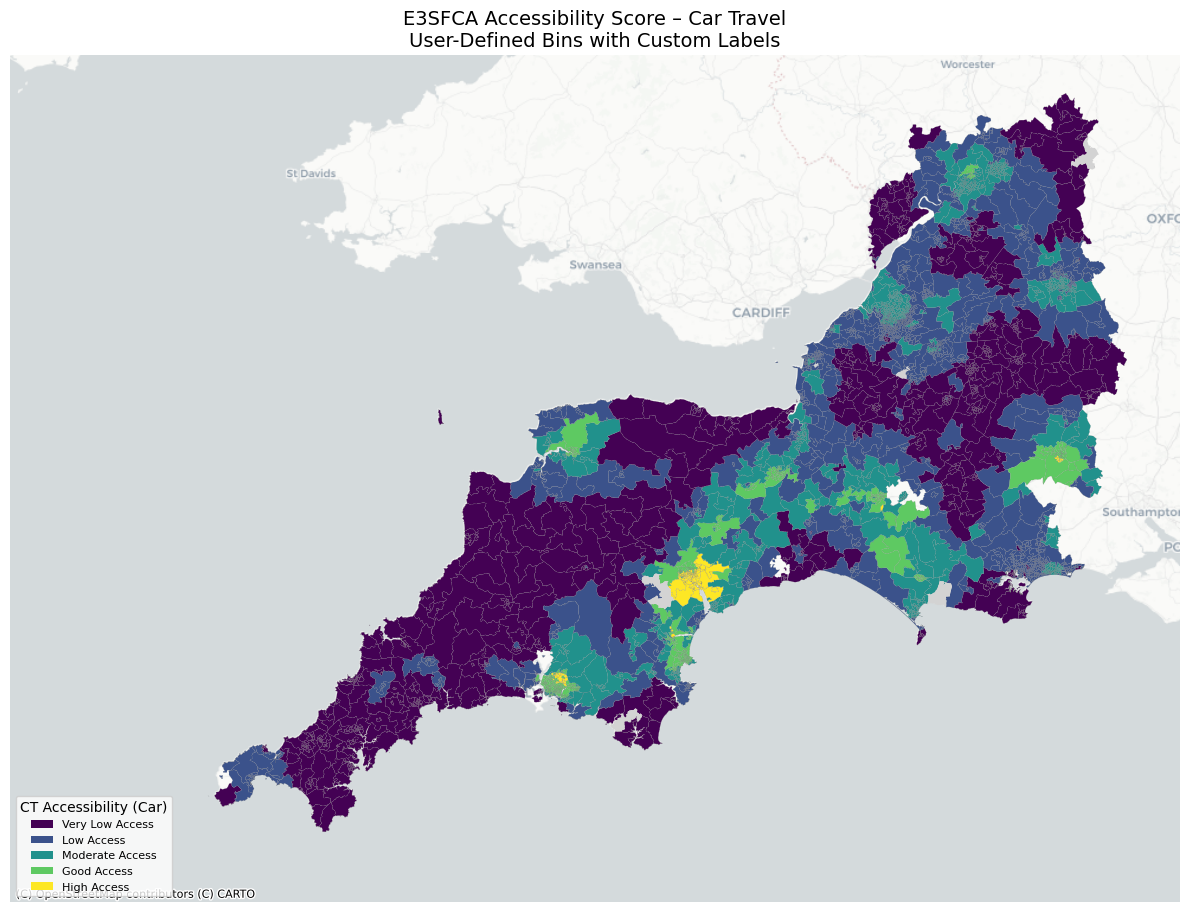

In [19]:
# ----------------------------------------------------------
# Step 8 – Plot with Custom Labels for Accessibility Bins
# ----------------------------------------------------------

from matplotlib.patches import Patch
import matplotlib as mpl

# 1. Reproject to Web Mercator
gdf_lsoa_plot = gdf_lsoa.to_crs(epsg=3857)

# 2. Drop missing values
gdf_valid = gdf_lsoa_plot[gdf_lsoa_plot["e3sfca_score_car"].notna()].copy()

# 3. Define user-defined bins and classify
bins = [0.00000, 0.00005, 0.00010, 0.00015, 0.00020, 0.00030]
classifier = mapclassify.UserDefined(gdf_valid["e3sfca_score_car"], bins=bins)
gdf_valid["access_bin"] = classifier.yb

# 4. Define custom bin labels
bin_labels = [
    "Very Low Access",    # < 0.00005
    "Low Access",         # 0.00005 – 0.00010
    "Moderate Access",    # 0.00010 – 0.00015
    "Good Access",        # 0.00015 – 0.00020
    "High Access"         # > 0.00020
]

# 5. Set colour map and hex colours
cmap = plt.cm.get_cmap("viridis", len(bin_labels))
bin_colours = [mpl.colors.to_hex(cmap(i)) for i in range(len(bin_labels))]

# 6. Plot
fig, ax = plt.subplots(figsize=(12, 10))

gdf_valid.plot(
    column="access_bin",
    cmap=cmap,
    categorical=True,
    legend=False,
    edgecolor="grey",
    linewidth=0.1,
    ax=ax
)

# Plot LSOAs with NaN scores as grey
gdf_lsoa_plot[gdf_lsoa_plot["e3sfca_score_car"].isna()].plot(
    ax=ax,
    color="lightgrey",
    edgecolor="none"
)

# Add basemap
ctx.add_basemap(ax, crs=gdf_lsoa_plot.crs, source=ctx.providers.CartoDB.Positron)

# Add custom legend with accessibility labels
handles = [Patch(facecolor=col, label=lbl) for col, lbl in zip(bin_colours, bin_labels)]
ax.legend(
    handles=handles,
    title="CT Accessibility (Car)",
    title_fontsize=10,
    fontsize=8,
    loc="lower left",
    frameon=True
)

# Final formatting
ax.set_title("E3SFCA Accessibility Score – Car Travel\nUser-Defined Bins with Custom Labels", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


## Map Interpretation: E3SFCA CT Accessibility Score (Car Mode)

This map visualises CT scanner accessibility across the South West region using the Enhanced 3-Step Floating Catchment Area (E3SFCA) method with car travel times. Accessibility scores are calculated based on both:

- Travel time from each LSOA to reachable CT sites (with decay)
- The availability and load at each CT site (supply-to-demand ratio)

### Key Findings:

- **Very Low Access (purple)**: Large rural and coastal areas, especially in Cornwall, North Devon, and parts of Somerset and Dorset, show very limited access to CT scanners. These LSOAs are far from CT facilities or rely on overburdened sites.
  
- **Low to Moderate Access (blue–green)**: Many semi-rural areas fall into these mid-access categories, indicating they have some coverage, but not enough to ensure timely or convenient access.

- **Good Access (light green)**: These areas tend to be within 10–20 minutes of one or more CT-capable facilities that are not heavily loaded.

- **High Access (yellow)**: Concentrated around key urban centres such as Exeter, Plymouth, Bristol, and parts of South Devon and Wiltshire. These areas benefit from proximity to multiple CT scanners with reasonable capacity.

### Interpretation Notes:

- The decay function means that accessibility rapidly diminishes beyond 20–30 minutes of travel.
- Supply-to-demand ratio at CT sites plays a critical role — even if a site is nearby, its accessibility score is reduced if demand is high.
- NaN (grey) areas represent LSOAs with no reachable CT site within the 60-minute threshold used in filtering.

This map supports prioritising underserved areas for CT scanner placement, particularly in parts of Cornwall, North Devon, and central Somerset where access is lowest.


In [20]:
# ----------------------------------------------------------
# Step 9 – Export E3SFCA Outputs to New Folder
# ----------------------------------------------------------

# Define new export directory
e3sfca_dir = os.path.join(
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed",
    "E3SFCA"
)
os.makedirs(e3sfca_dir, exist_ok=True)

# 1. Export LSOA GeoDataFrame with E3SFCA score
lsoa_gpkg_path = os.path.join(e3sfca_dir, "lsoa_e3sfca_accessibility_2024.gpkg")
gdf_lsoa.to_file(lsoa_gpkg_path, layer="lsoa", driver="GPKG")

# 2. Export CSV version of same (without geometry)
lsoa_csv_path = os.path.join(e3sfca_dir, "lsoa_e3sfca_accessibility_2024.csv")
gdf_lsoa.drop(columns="geometry").to_csv(lsoa_csv_path, index=False)

# 3. Export filtered travel matrix (car mode only, ≤60 min, CT destinations)
travel_car_path = os.path.join(e3sfca_dir, "lsoa_to_ct_travel_matrix_car.csv")
df_travel_car.to_csv(travel_car_path, index=False)

# 4. Export CT site capability table (with scanner info and LSOA codes)
ct_sites_path = os.path.join(e3sfca_dir, "ct_sites_capability.csv")
df_sites_ct.to_csv(ct_sites_path, index=False)

# 5. Export Rj values (supply-to-weighted demand per CT site)
rj_path = os.path.join(e3sfca_dir, "ct_site_rj_scores_car.csv")
df_rj_car.to_csv(rj_path, index=False)

print("All E3SFCA files exported to:", e3sfca_dir)


All E3SFCA files exported to: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/E3SFCA
